
# Mount GDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:
!unzip "/content/drive/MyDrive/LSPD Dataset/val_v4.zip" -d "/content/LSPD"

Streaming output truncated to the last 5000 lines.
  inflating: /content/LSPD/val_v4/image_1025897.jpg  
  inflating: /content/LSPD/val_v4/image_1025896.jpg  
  inflating: /content/LSPD/val_v4/image_1025895.jpg  
  inflating: /content/LSPD/val_v4/image_1025894.jpg  
  inflating: /content/LSPD/val_v4/image_1025891.jpg  
  inflating: /content/LSPD/val_v4/image_1025890.jpg  
  inflating: /content/LSPD/val_v4/image_1025888.jpg  
  inflating: /content/LSPD/val_v4/image_1025887.jpg  
  inflating: /content/LSPD/val_v4/image_1025885.jpg  
  inflating: /content/LSPD/val_v4/image_1025882.jpg  
  inflating: /content/LSPD/val_v4/image_1025880.jpg  
  inflating: /content/LSPD/val_v4/image_1025879.jpg  
  inflating: /content/LSPD/val_v4/image_1025878.jpg  
  inflating: /content/LSPD/val_v4/image_1025877.jpg  
  inflating: /content/LSPD/val_v4/image_1025874.jpg  
  inflating: /content/LSPD/val_v4/image_1025870.jpg  
  inflating: /content/LSPD/val_v4/image_1025868.jpg  
  inflating: /content/LSPD/val_

In [1]:
!pip install pycocotools

In [2]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


Create kayo account sa RoboFlow.
->Account->Settings->API keys->Copy private key->google colab (here)-> secret keys->add secret key name API_KEY

In [3]:
from roboflow import Roboflow
from google.colab import userdata

rf = Roboflow(userdata.get('API_KEY'))
project = rf.workspace("securityviolence").project("violence-detection-p4qev")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to violence-detection-4 in coco:: 100%|██████████| 6134/6134 [00:01<00:00, 5735.55it/s]


# Training

## Imports

In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

## Transformation

In [5]:
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

## Initialize dataset

In [8]:
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/violence-detection-4/train",
    ann_file="/content/violence-detection-4/train/annotation/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/violence-detection-4/valid",
    ann_file="/content/violence-detection-4/valid/annotation/_annotations.coco.json"
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Load Faster R-CNN with ResNet-50

In [9]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

## Initialize model

In [10]:
num_classes = 3 # violence-no_violence, non_violence, violence
model = get_model(num_classes)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 132MB/s]


## Use Cuda if available

In [11]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Train

In [12]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Training Loss: {losses.item():.4f}")

In [13]:
def evaluate_loss(model, data_loader, device):
    """
    Run one pass through val_loader and return the average loss.
    Uses train() so the model produces a loss dict, but disables
    gradient tracking so nothing is updated.
    """
    was_training = model.training            # remember current state
    model.train()                            # need training mode for loss dict
    total_loss, n_batches = 0.0, 0

    with torch.no_grad():                    # no grads / no param updates
        for images, targets in data_loader:
            images = [img.to(device) for img in images]

            # --- same preprocessing you already use -------------------------
            processed_targets, valid_images = [], []
            for i, target in enumerate(targets):
                boxes, labels = [], []
                for obj in target:
                    x, y, w, h = obj["bbox"]
                    if w > 0 and h > 0:
                        boxes.append([x, y, x + w, y + h])
                        labels.append(obj["category_id"])
                if boxes:
                    processed_targets.append({
                        "boxes":  torch.tensor(boxes, dtype=torch.float32).to(device),
                        "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                    })
                    valid_images.append(images[i])
            if not processed_targets:
                continue
            images = valid_images
            # ----------------------------------------------------------------

            # forward → dict of individual losses
            loss_dict = model(images, processed_targets)
            batch_loss = sum(loss for loss in loss_dict.values()).item()
            total_loss += batch_loss
            n_batches += 1

    # restore the original mode (train or eval)
    model.train(was_training)

    return total_loss / max(n_batches, 1)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # ---- validation ----
    val_loss = evaluate_loss(model, val_loader, device)
    print(f"Epoch [{epoch}]  Validation Loss: {val_loss:.4f}")

    # ---- save checkpoint ----
    torch.save(model.state_dict(), f"fasterrcnn_resnet50_epoch_{epoch+1}.pth")


Epoch [0] Loss: 0.1972
Epoch [0]  Validation Loss: 0.2033
Epoch [1] Loss: 0.2377
Epoch [1]  Validation Loss: 0.1850
Epoch [2] Loss: 0.1398
Epoch [2]  Validation Loss: 0.1819
Epoch [3] Loss: 0.1325
Epoch [3]  Validation Loss: 0.1644


# Testing

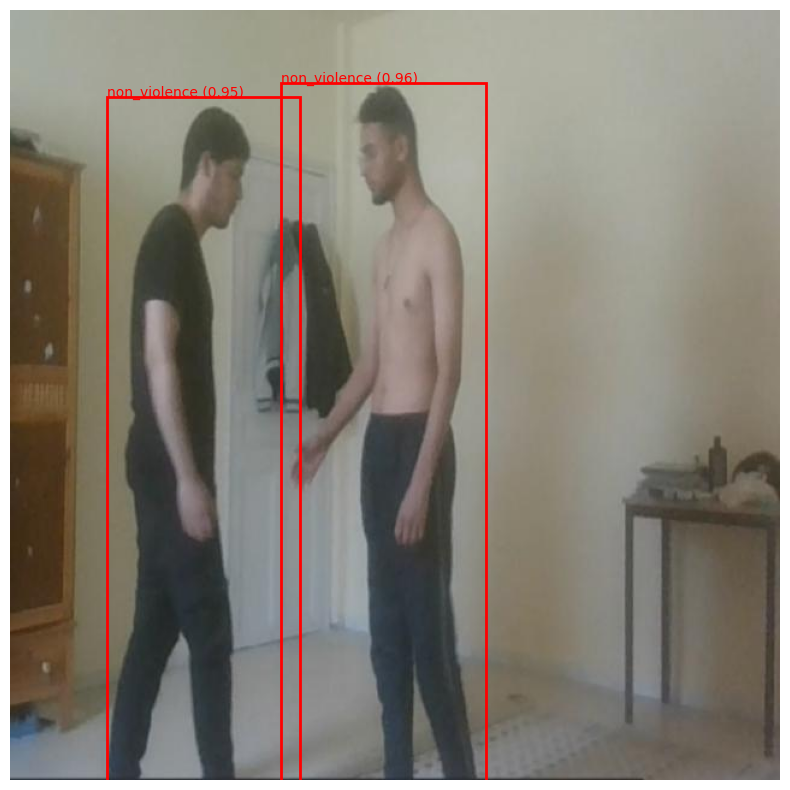

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 3  # violence-no_violence, non_violence, violence

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("fasterrcnn_resnet50_epoch_4.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "/content/violence-detection-4/valid/Capture-d-ecran-2024-05-15-161621_png.rf.bfd2a53f6cf2e39c76795d9b4ad29136.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "violence-no_violence", 1: "non_violence", 2: "violence"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5

    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')

    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

# Evaluation Metrics

In [ ]:
import torch
import numpy as np
import warnings
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Confusion Matrix and Performance Metrics

In [ ]:
y_true, y_pred = [], []

for images, targets in val_loader:
    images = [img.to(device) for img in images]
    with torch.no_grad():
        outputs = model(images)

    for output, target_list in zip(outputs, targets):
        # GT: if any category_id == 1
        true_label = 1 if any(ann["category_id"] == 1 for ann in target_list) else 0
        # Pred: if any detection score > 0.8
        pred_label = 1 if any(score > 0.8 for score in output["scores"].cpu().numpy()) else 0

        y_true.append(true_label)
        y_pred.append(pred_label)

# Compute classification metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)
accuracy  = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

Precision: 0.8706
Recall:    0.7822
F1 Score:  0.8241
Accuracy:  0.7047


In [ ]:
# Verifies using confusion
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # rows=actual, cols=predicted
tp = cm[0, 0]   # actual 1, predicted 1
fn = cm[0, 1]   # actual 1, predicted 0
fp = cm[1, 0]   # actual 0, predicted 1
tn = cm[1, 1]   # actual 0, predicted 0

print("\nConfusion matrix counts")
print(f"TP: {tp} | FN: {fn} | FP: {fp} | TN: {tn}")

# Manual formulas (should match sklearn)
precision_m = tp / (tp + fp) if tp + fp else 0
recall_m    = tp / (tp + fn) if tp + fn else 0
accuracy_m  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0
f1_m        = 2 * precision_m * recall_m / (precision_m + recall_m) if (precision_m + recall_m) else 0

print("\nManual check")
print(f"Precision : {precision_m:.4f}")
print(f"Recall    : {recall_m:.4f}")
print(f"F1-Score  : {f1_m:.4f}")
print(f"Accuracy  : {accuracy_m:.4f}")


Confusion matrix counts
TP: 370 | FN: 103 | FP: 55 | TN: 7

Manual check
Precision : 0.8706
Recall    : 0.7822
F1-Score  : 0.8241
Accuracy  : 0.7047


## mAp, Average Presion, Average Recall

In [ ]:
val_results = []

for images, targets in val_loader:
    images = [img.to(device) for img in images]
    with torch.no_grad():
        outputs = model(images)

    for output, target_list in zip(outputs, targets):
        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()
        labels = output["labels"].cpu().numpy()

        if target_list:
          image_id = int(target_list[0]["image_id"]) if isinstance(target_list[0]["image_id"], (int, np.integer)) else int(target_list[0]["image_id"].item())

          for box, score, label in zip(boxes, scores, labels):
              x_min, y_min, x_max, y_max = box
              width  = x_max - x_min
              height = y_max - y_min

              val_results.append({
                  "image_id": image_id,
                  "category_id": int(label),
                  "bbox": [x_min, y_min, width, height],
                  "score": float(score)
              })

## Evaluation

In [ ]:
val_coco = COCO("/content/violence-detection-4/valid/annotation/_annotations.coco.json")
print("Running COCO mAP evaluation...")
coco_dt = val_coco.loadRes(val_results)
coco_eval = COCOeval(val_coco, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Running COCO mAP evaluation...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.53s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.509
 Average Recall     (AR) @[ IoU=0